# Experiment Introduction

**_Can we make MAGAIL fail simply by giving it two identical pure NE?_**

**Objective:**  
Demonstrate that, in a game with two equally good pure-Nash equilibria and no other structural tie-breaker, MAGAIL without entropy will arbitrarily "collapse" to one of them (and be unstable across runs), whereas MAGAIL with entropy consistently finds the unique maximum-entropy mixture.

**Hypothesis:**  
Without entropy ($\beta=0$): MAGAIL's generator-discriminator loop has no in-built way to break the symmetry between the two pure equilibria, so small random fluctuations or initialization biases will tip it to either equilibrium A or B, and different random seeds will yield different outcomes.  
With entropy ($\beta > 0$): The entropy bonus makes the mixed strategy (50% A and 50% B) the unique maximum-entropy equilibrium. MAGAIL will reliably converge there, regardless of seed.

**Environment:**  
Two agents: Agent 1, Agent 2  
Actions: each agent $i \in \{1,2\}$ chooses from $\{A,B\}$  
Transition: one single step, then the episode ends  
Payoffs: $r_i(a_1, a_2) = +1$ if $a_1=a_2 \in \{A,B\}$ and 0 otherwise

|                | **Agent 2: A** | **Agent 2: B** |
|----------------|----------------|----------------|
| **Agent 1: A** | (1, 1)         | (0, 0)         |
| **Agent 1: B** | (0, 0)         | (1, 1)         |

This game has exactly two pure strategy Nash equilibria $(A,A)$ and $(B,B)$.  
There is also a symmetric mixed NE at $\pi_i(A)=\pi_i(B)=0.5$, but without entropy there is no "force" pushing towards it.

**MAGAIL:**  
No entropy ⇒ Standard Nash-best-response: $\beta=0$  
With entropy ⇒ Max-entropy Nash: $\beta>0$ (solve $\arg\max H(\pi)$ among equilibria)

**Experiment:**  
- Implement MAGAIL  
- Fix hyperparameters (learning rate and batch sizes) kept identical across runs  
- Train per seed and per $\beta$  
- THINK ABOUT METRICS TO EVALUATE (convergence stability? joint action frequency? reconstruction error?)  
- Plot results

**Expected results:**  
When we run MAGAIL without any entropy regularization, we expect the learned policies to “break the tie” between the two equally good coordination conventions in an essentially random way: some random seeds will converge to always playing $(A,A)$, while others will converge to always playing $(B,B)$. Early in training we expect to often see the policy oscillate or shift non-negligibly between A and B as small gradient or sampling fluctuations push it toward whichever corner it happens to favor at that moment. As a result, the divergence metric, measuring how much the policy changes from one iteration to the next, will remain relatively high for longer and may never fully settle to zero.

By contrast, when we include a modest entropy bonus, the algorithm gains a built-in preference for maximizing randomness, which makes the unique 50/50 mixed strategy the sole optimum. Across all random seeds, MAGAIL then smoothly drives each agent’s action probabilities to exactly 0.5 for A and 0.5 for B. The divergence curve for the entropy-regularized runs will plummet toward zero and stay flat, indicating stable convergence to that single maximum-entropy equilibrium rather than flipping between pure conventions.

---

**Implementation of Experiment**  
The hard point is how to implement MAGAIL in a tabular way.  
And since we have a very small state action space, we need to find a way to implement MAGAIL correctly.

---

**Possible Metrics to Evaluate**

1. **The variance of learnt policy across seeds**  
   - Without entropy: The learnt policy randomly commits to 100% (A,A) or (B,B). The variance across seeds should be **high**.
   - With entropy: The learnt policy balances the choice of (A,A) or (B,B), converging to a 50%/50% mixed strategy. Variance across seeds should be **low**.

2. **Reconstruction Error**  
   Measure the distance between the learnt policy and the expert policy. We can use the Jensen-Shannon Divergence (JS Divergence), which is symmetric and always finite.

   Let $\pi_E$ be the expert's policy distribution over the set of actions $\mathcal{A}$, and $\pi_\theta$ be the learned agent's policy.

   $$
   \mathrm{JSD}(\pi_E \Vert \pi_\theta) = \frac{1}{2} D_{KL}(\pi_E \Vert M) + \frac{1}{2} D_{KL}(\pi_\theta \Vert M)
   $$

   where:
   - $D_{KL}$ is the Kullback-Leibler (KL) divergence.
   - $M$ is the mixture distribution, defined as $M = \frac{1}{2}(\pi_E + \pi_\theta)$.

# Expert Demonstrations
Expert demonstrations: Generate a fixed dataset of N expert trajectories.

The mixed strategy

Given two agent, both have  mixed strategy of choosing 50\% A and 50 \% B, the distribution of their joint actions will naturally be 25\% (A,A), 25\% (A,B), 25\% (B,A), and 25\% (B,B). This is because both agents are acting individually without know what another agent will act.

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.spatial.distance import jensenshannon
from collections import defaultdict
import seaborn as sns

# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

print("Libraries imported successfully!")

Libraries imported successfully!


In [132]:
class CoordinationGame:
    """
    Simple coordination game environment
    - Single state (one-shot game)
    - Two agents, each chooses A(0) or B(1)
    - Reward: +1 if actions match, 0 otherwise
    """
    def __init__(self):
        self.num_agents = 2
        self.num_actions = 2  # A=0, B=1
        self.state = 0  # Single state
        
    def reset(self):
        """Reset environment - nothing to do for one-shot game"""
        return {"agent_0": self.state, "agent_1": self.state}
    
    def step(self, actions):
        """
        Execute one step
        actions: dict {"agent_0": action_0, "agent_1": action_1}
        """
        a0, a1 = actions["agent_0"], actions["agent_1"]
        
        # Coordination reward: +1 if same action, 0 otherwise
        reward = 1.0 if a0 == a1 else 0.0
        rewards = {"agent_0": reward, "agent_1": reward}
        
        # Episode always terminates after one step
        dones = {"agent_0": True, "agent_1": True}
        next_obs = {"agent_0": self.state, "agent_1": self.state}
        
        return next_obs, rewards, dones, {}

print("Coordination game environment created!")

Coordination game environment created!


In [133]:
class TabularPolicy:
    """
    Tabular policy for single-state coordination game
    Directly stores action probabilities as parameters
    """
    def __init__(self, num_actions=2, init_uniform=True):
        self.num_actions = num_actions
        if init_uniform:
            # Initialize with uniform random policy
            # This is the ONLY learnable parameter - a 2D vector for actions A and B
            self.logits = torch.zeros(num_actions, requires_grad=True)
        else:
            # Initialize with small random values
            self.logits = torch.nn.Parameter(torch.randn(num_actions) * 0.1)

    def get_probs(self):
        """Get action probabilities using softmax"""
        # Converts logits to probabilities via softmax
        return F.softmax(self.logits, dim=0)  # [P(A), P(B)]
    
    def sample_action(self):
        """Sample an action from the policy"""
        probs = self.get_probs()
        action = torch.multinomial(probs, 1).item()
        return action
    
    def log_prob(self, action):
        """Get log probability of a specific action"""
        log_probs = F.log_softmax(self.logits, dim=0)
        return log_probs[action]
    
    def entropy(self):
        """Calculate policy entropy"""
        probs = self.get_probs()
        log_probs = F.log_softmax(self.logits, dim=0)
        return -(probs * log_probs).sum()

class TabularDiscriminator:
    """
    Simple tabular discriminator for joint state-action pairs
    Since we have single state and 2x2 actions, we have 4 possible joint actions
    """
    def __init__(self):
        # 4 joint actions: (A,A), (A,B), (B,A), (B,B) -> indices 0,1,2,3
        # Initially, all joint actions get sigmoid(0) = 0.5, meaning the discriminator is completely uncertain.
        self.logits = torch.zeros(4, requires_grad=True)
    
    def joint_action_to_index(self, action_0, action_1):
        """Convert joint action to index: (a0,a1) -> a0*2 + a1"""
        return action_0 * 2 + action_1
    
    def forward(self, action_0, action_1):
        """
        Forward pass: return probability that (action_0, action_1) comes from expert
        """
        idx = self.joint_action_to_index(action_0, action_1)
        return torch.sigmoid(self.logits[idx])

print("Tabular policy and discriminator classes defined!")

Tabular policy and discriminator classes defined!


In [134]:
def generate_expert_data(num_episodes=1000):
    """
    Generate expert demonstrations using 50/50 mixed strategy
    Each agent chooses A or B with 50% probability independently
    """
    expert_data = []
    
    for _ in range(num_episodes):
        # Expert policy: 50% A, 50% B for each agent
        action_0 = np.random.choice([0, 1])  # A=0, B=1
        action_1 = np.random.choice([0, 1])
        
        expert_data.append({
            "state": 0,  # Single state
            "actions": {"agent_0": action_0, "agent_1": action_1},
            "joint_action": (action_0, action_1)
        })
    
    return expert_data

def generate_asymmetric_bimodal_expert_data(num_episodes=1000, AA_ratio=0.7):
    """
    Generate expert demonstrations with asymmetric bimodal patterns
    E.g., 70% (A,A) and 30% (B,B) to test if MAGAIL can learn this asymmetry
    """
    expert_data = []
    
    num_AA_episodes = int(num_episodes * AA_ratio)
    num_BB_episodes = num_episodes - num_AA_episodes
    
    # Generate (A,A) coordination episodes
    for _ in range(num_AA_episodes):
        expert_data.append({
            "state": 0,
            "actions": {"agent_0": 0, "agent_1": 0},
            "joint_action": (0, 0)
        })
    
    # Generate (B,B) coordination episodes  
    for _ in range(num_BB_episodes):
        expert_data.append({
            "state": 0,
            "actions": {"agent_0": 1, "agent_1": 1},
            "joint_action": (1, 1)
        })
    
    np.random.shuffle(expert_data)
    
    print(f"Generated asymmetric bimodal expert data: {num_AA_episodes} (A,A) episodes ({AA_ratio*100:.1f}%), {num_BB_episodes} (B,B) episodes ({(1-AA_ratio)*100:.1f}%)")
    return expert_data

def generate_noisy_bimodal_expert_data(num_episodes=1000, noise_level=0.1):
    """
    Generate bimodal expert data with some noise
    Mostly (A,A) and (B,B), but with some miscoordination episodes
    """
    expert_data = []
    
    # Calculate episodes for each type
    num_coordination = int(num_episodes * (1 - noise_level))
    num_AA = num_coordination // 2
    num_BB = num_coordination - num_AA
    num_noise = num_episodes - num_coordination
    
    # Perfect coordination episodes
    for _ in range(num_AA):
        expert_data.append({
            "state": 0,
            "actions": {"agent_0": 0, "agent_1": 0},
            "joint_action": (0, 0)
        })
    
    for _ in range(num_BB):
        expert_data.append({
            "state": 0,
            "actions": {"agent_0": 1, "agent_1": 1},
            "joint_action": (1, 1)
        })
    
    # Add noise episodes (miscoordination)
    for _ in range(num_noise):
        if np.random.random() < 0.5:
            # (A,B) miscoordination
            expert_data.append({
                "state": 0,
                "actions": {"agent_0": 0, "agent_1": 1},
                "joint_action": (0, 1)
            })
        else:
            # (B,A) miscoordination
            expert_data.append({
                "state": 0,
                "actions": {"agent_0": 1, "agent_1": 0},
                "joint_action": (1, 0)
            })
    
    np.random.shuffle(expert_data)
    
    print(f"Generated noisy bimodal expert data: {num_AA} (A,A), {num_BB} (B,B), {num_noise} miscoordination ({noise_level*100:.1f}% noise)")
    return expert_data

In [135]:

def collect_policy_trajectories(policies, num_episodes=100):
    """
    Collect trajectories from current policies
    """
    env = CoordinationGame()
    trajectories = []
    
    for _ in range(num_episodes):
        obs = env.reset()
        
        # Sample actions from policies
        action_0 = policies["agent_0"].sample_action()
        action_1 = policies["agent_1"].sample_action()
        actions = {"agent_0": action_0, "agent_1": action_1}
        
        # Get log probabilities for policy gradient
        log_prob_0 = policies["agent_0"].log_prob(action_0)
        log_prob_1 = policies["agent_1"].log_prob(action_1)
        
        trajectories.append({
            "state": 0,
            "actions": actions,
            "joint_action": (action_0, action_1),
            "log_probs": {"agent_0": log_prob_0, "agent_1": log_prob_1}
        })
    
    return trajectories

print("Data generation functions defined!")

Data generation functions defined!


In [136]:
class MAGAILTrainer:
    """
    MAGAIL trainer for the coordination game
    """
    def __init__(self, beta=0.0, lr_policy=0.01, lr_disc=0.01, policy_init_uniform=True):
        self.beta = beta  # Entropy regularization coefficient
        self.lr_policy = lr_policy
        self.lr_disc = lr_disc
        
        # Initialize policies and discriminator
        self.policies = {
            "agent_0": TabularPolicy(init_uniform=policy_init_uniform),
            "agent_1": TabularPolicy(init_uniform=policy_init_uniform)
        }
        self.discriminator = TabularDiscriminator()
        
        # Optimizers
        self.policy_optimizers = {
            "agent_0": torch.optim.Adam([self.policies["agent_0"].logits], lr=lr_policy),
            "agent_1": torch.optim.Adam([self.policies["agent_1"].logits], lr=lr_policy)
        }
        self.disc_optimizer = torch.optim.Adam([self.discriminator.logits], lr=lr_disc)
        
        # Training history
        self.history = {
            "policy_probs": {"agent_0": [], "agent_1": []},
            "disc_loss": [],
            "policy_loss": {"agent_0": [], "agent_1": []},
            "entropy": {"agent_0": [], "agent_1": []},
            "joint_action_dist": []
        }
    
    def update_discriminator(self, expert_data, policy_data, batch_size=32):
        """Update discriminator to distinguish expert from policy data"""
        # Sample batches
        expert_batch = np.random.choice(expert_data, size=min(batch_size, len(expert_data)), replace=False)
        policy_batch = np.random.choice(policy_data, size=min(batch_size, len(policy_data)), replace=False)
        
        # Calculate discriminator loss
        expert_loss = 0.0
        policy_loss = 0.0
        
        for traj in expert_batch:
            a0, a1 = traj["joint_action"]
            expert_prob = self.discriminator.forward(a0, a1)
            # The higher the expert_prob, the less the loss
            expert_loss += -torch.log(expert_prob + 1e-8)  # Want high prob for expert
        
        for traj in policy_batch:
            a0, a1 = traj["joint_action"]
            policy_prob = self.discriminator.forward(a0, a1)
            # The lower the policy_prob, the less the loss
            policy_loss += -torch.log(1 - policy_prob + 1e-8)  # Want low prob for policy
        
        disc_loss = (expert_loss + policy_loss) / (len(expert_batch) + len(policy_batch))
        
        # Update discriminator
        self.disc_optimizer.zero_grad()
        disc_loss.backward()
        self.disc_optimizer.step()
        
        return disc_loss.item()
    
    def update_policies(self, policy_data, batch_size=32):
        """Update policies using discriminator rewards and entropy bonus"""
        # Sample batch
        batch = np.random.choice(policy_data, size=min(batch_size, len(policy_data)), replace=False)
        
        policy_losses = {"agent_0": 0.0, "agent_1": 0.0}
        
        for traj in batch:
            a0, a1 = traj["joint_action"]
            
            # Get discriminator reward (want high discrimination score)
            with torch.no_grad():
                reward = torch.log(self.discriminator.forward(a0, a1) + 1e-8)
            
            # Policy gradient loss for each agent
            for agent in ["agent_0", "agent_1"]:
                log_prob = traj["log_probs"][agent]
                
                # REINFORCE loss: -log_prob * reward
                policy_loss = -log_prob * reward
                
                # Add entropy bonus (want to maximize entropy)
                if self.beta > 0:
                    entropy_bonus = -self.beta * self.policies[agent].entropy()
                    policy_loss += entropy_bonus
                
                policy_losses[agent] += policy_loss
        
        # Normalize by batch size
        for agent in ["agent_0", "agent_1"]:
            policy_losses[agent] /= len(batch)
        
        # Update policies
        for agent in ["agent_0", "agent_1"]:
            self.policy_optimizers[agent].zero_grad()
            policy_losses[agent].backward()
            self.policy_optimizers[agent].step()
        
        return {agent: loss.item() for agent, loss in policy_losses.items()}
    
    def train(self, expert_data, num_epochs=500, batch_size=32, collect_every=10):
        """Main training loop"""
        for epoch in range(num_epochs):
            # Collect policy trajectories
            policy_data = collect_policy_trajectories(self.policies, num_episodes=100)
            
            # Update discriminator
            disc_loss = self.update_discriminator(expert_data, policy_data, batch_size)
            
            # Update policies
            policy_losses = self.update_policies(policy_data, batch_size)
            
            # Record statistics
            if epoch % collect_every == 0:
                self.record_statistics(disc_loss, policy_losses)
    
    def record_statistics(self, disc_loss, policy_losses):
        """Record training statistics"""
        # Policy probabilities
        for agent in ["agent_0", "agent_1"]:
            probs = self.policies[agent].get_probs().detach().numpy()
            self.history["policy_probs"][agent].append(probs.copy())
        
        # Losses
        self.history["disc_loss"].append(disc_loss)
        for agent in ["agent_0", "agent_1"]:
            self.history["policy_loss"][agent].append(policy_losses[agent])
        
        # Entropies
        for agent in ["agent_0", "agent_1"]:
            entropy = self.policies[agent].entropy().item()
            self.history["entropy"][agent].append(entropy)
        
        # Joint action distribution
        probs_0 = self.policies["agent_0"].get_probs().detach().numpy()
        probs_1 = self.policies["agent_1"].get_probs().detach().numpy()
        joint_dist = np.outer(probs_0, probs_1).flatten()  # [P(A,A), P(A,B), P(B,A), P(B,B)]
        self.history["joint_action_dist"].append(joint_dist)

print("MAGAIL trainer class defined!")

MAGAIL trainer class defined!


In [137]:
def run_experiment(seeds=[42, 123, 456, 789, 999], 
                          beta_values=[0.0, 0.1, 0.5, 1.0], 
                          num_epochs=500,
                          expert_type="bimodal",
                          policy_init_uniform=True):
    """
    Run experiment with different expert data types
    """
    # Generate different types of expert data
    if expert_type == "mixed":
        expert_data = generate_expert_data(num_episodes=1000)
    elif expert_type == "bimodal":
        expert_data = generate_asymmetric_bimodal_expert_data(num_episodes=1000, AA_ratio=0.5)
    elif expert_type == "asymmetric":
        expert_data = generate_asymmetric_bimodal_expert_data(num_episodes=1000, AA_ratio=0.7)
    elif expert_type == "noisy":
        expert_data = generate_noisy_bimodal_expert_data(num_episodes=1000, noise_level=0.1)
    elif expert_type == "all_AA":
        expert_data = generate_asymmetric_bimodal_expert_data(num_episodes=1000, AA_ratio=1.0)
    else:
        raise ValueError(f"Unknown expert_type: {expert_type}")
    
    print(f"Generated {len(expert_data)} expert trajectories of type '{expert_type}'")
    
    # Store results
    results = {}
    
    for beta in beta_values:
        print(f"\nRunning experiments with β = {beta}")
        results[beta] = {}
        
        for seed in seeds:
            print(f"  Seed {seed}...", end="")
            set_seed(seed)
            
            # Create and train MAGAIL
            trainer = MAGAILTrainer(beta=beta, policy_init_uniform=policy_init_uniform)
            trainer.train(expert_data, num_epochs=num_epochs)
            
            # Store final policy probabilities
            final_probs = {
                "agent_0": trainer.policies["agent_0"].get_probs().detach().numpy(),
                "agent_1": trainer.policies["agent_1"].get_probs().detach().numpy()
            }
            
            results[beta][seed] = {
                "final_probs": final_probs,
                "history": trainer.history
            }
            print(" Done!")
    
    return results, expert_data

print("Experiment runner defined!")

Experiment runner defined!


# Evaluation

In [138]:
def analyze_results(results, expert_type="bimodal"):
    """
    Analyze experimental results and compute key metrics
    """
    analysis = {}
    

    for beta in results.keys():
        print(f"\n=== Analysis for β = {beta} ===")
        
        # Collect final probabilities across seeds
        prob_A_agent0 = []
        prob_A_agent1 = []
        
        for seed in results[beta].keys():
            final_probs = results[beta][seed]["final_probs"]
            prob_A_agent0.append(final_probs["agent_0"][0])  # P(A) for agent 0
            prob_A_agent1.append(final_probs["agent_1"][0])  # P(A) for agent 1
        
        # Calculate variance across seeds
        var_agent0 = np.var(prob_A_agent0)
        var_agent1 = np.var(prob_A_agent1)
        mean_prob_A_agent0 = np.mean(prob_A_agent0)
        mean_prob_A_agent1 = np.mean(prob_A_agent1)
        
        print(f"Agent 0 - Mean P(A): {mean_prob_A_agent0:.3f}, Variance: {var_agent0:.6f}")
        print(f"Agent 1 - Mean P(A): {mean_prob_A_agent1:.3f}, Variance: {var_agent1:.6f}")
        
        # Calculate Jensen-Shannon divergence from expert policy
        mean_js, var_js = calculate_js_divergence(results, beta, expert_type)
        print(f"JS Divergence - Mean: {mean_js:.6f}, Variance: {var_js:.8f}")
        
        analysis[beta] = {
            "prob_A_variance": {"agent_0": var_agent0, "agent_1": var_agent1},
            "prob_A_mean": {"agent_0": mean_prob_A_agent0, "agent_1": mean_prob_A_agent1},
            "js_divergence": {"mean": mean_js, "variance": var_js},
            "final_probs_all_seeds": {
                "agent_0": prob_A_agent0,
                "agent_1": prob_A_agent1
            }
        }
    
    return analysis

def calculate_js_divergence(results, beta, expert_type):
        
    # Calculate Jensen-Shannon divergence from expert (uniform) policy
    expert_policy = calculate_expert_policy(expert_type)
    js_divergences = []
    
    for seed in results[beta].keys():
        final_probs = results[beta][seed]["final_probs"]
        
        # JS divergence for both agents
        js_0 = jensenshannon(expert_policy, final_probs["agent_0"])
        js_1 = jensenshannon(expert_policy, final_probs["agent_1"])
        js_divergences.append((js_0 + js_1) / 2)  # Average JS divergence
    
    mean_js = np.mean(js_divergences)
    var_js = np.var(js_divergences)
    return mean_js, var_js

def calculate_expert_policy(expert_type):
    """
    Calculate the expert policy based on the expert data type
    """
    if expert_type == "mixed":
        return np.array([0.5, 0.5])  # Uniform policy
    elif expert_type == "bimodal":
        return np.array([0.5, 0.5])  # TODO , it is hard to define 
    elif expert_type == "asymmetric":
        return np.array([0.7, 0.3])  # TODO 70% (A,A), 30% (B,B)
    elif expert_type == "noisy":
        return np.array([0.6, 0.4])  # TODO E.g., mostly (A,A) with some noise
    elif expert_type == "all_AA":
        return np.array([0.1, 0.0])  # TODO E.g., mostly (A,A) with some noise
    else:
        raise ValueError(f"Unknown expert_type: {expert_type}")
print("Analysis function defined!")

Analysis function defined!


# Plots

In [139]:
def plot_results(results, analysis):
    """
    Create comprehensive plots of the experimental results
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('MAGAIL Entropy Experiment Results', fontsize=16)
    
    beta_values = list(results.keys())
    seeds = list(results[beta_values[0]].keys())
    
    # Plot 1: Policy probability variance across beta values
    ax1 = axes[0, 0]
    variances_agent0 = [analysis[beta]["prob_A_variance"]["agent_0"] for beta in beta_values]
    variances_agent1 = [analysis[beta]["prob_A_variance"]["agent_1"] for beta in beta_values]
    
    x = np.arange(len(beta_values))
    width = 0.35
    ax1.bar(x - width/2, variances_agent0, width, label='Agent 0', alpha=0.8)
    ax1.bar(x + width/2, variances_agent1, width, label='Agent 1', alpha=0.8)
    ax1.set_xlabel('β (Entropy Coefficient)')
    ax1.set_ylabel('Variance of P(A) across seeds')
    ax1.set_title('Policy Variance vs Entropy Regularization')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'{beta}' for beta in beta_values])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: JS Divergence from expert (IMPROVED - better spacing)
    ax2 = axes[0, 1]
    js_means = [analysis[beta]["js_divergence"]["mean"] for beta in beta_values]
    js_vars = [analysis[beta]["js_divergence"]["variance"] for beta in beta_values]
    
    # Use wider bars and better spacing
    bar_width = 0.6
    x_pos = np.arange(len(beta_values))
    bars = ax2.bar(x_pos, js_means, width=bar_width, alpha=0.8, color='orange', 
                   yerr=np.sqrt(js_vars), capsize=5, error_kw={'linewidth': 2})
    
    ax2.set_xlabel('β (Entropy Coefficient)', fontsize=12)
    ax2.set_ylabel('JS Divergence from Expert', fontsize=12)
    ax2.set_title('Reconstruction Error vs Entropy Regularization', fontsize=12)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'{beta}' for beta in beta_values])
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on top of bars for better readability
    for i, (mean_val, std_val) in enumerate(zip(js_means, np.sqrt(js_vars))):
        ax2.text(i, mean_val + std_val + 0.001, f'{mean_val:.3f}', 
                ha='center', va='bottom', fontsize=10)
    
    # Plot 3: Final probability distributions (IMPROVED - reduced legend)
    ax3 = axes[0, 2]
    colors = ['blue', 'green', 'red', 'purple']
    markers = ['o', 's']
    
    for i, beta in enumerate(beta_values):
        probs_agent0 = analysis[beta]["final_probs_all_seeds"]["agent_0"]
        probs_agent1 = analysis[beta]["final_probs_all_seeds"]["agent_1"]
        
        # Add some jitter for visibility
        jitter = 0.02
        x_pos = [beta + np.random.uniform(-jitter, jitter) for _ in range(len(seeds))]
        
        # Only show legend for β=0.0 and β=0.1
        show_legend = beta in [0.0, 0.1]
        
        ax3.scatter(x_pos, probs_agent0, alpha=0.7, color=colors[i], marker=markers[0],
                   label=f'β={beta}, Agent 0' if show_legend else "", s=50)
        ax3.scatter(x_pos, probs_agent1, alpha=0.7, color=colors[i], marker=markers[1],
                   label=f'β={beta}, Agent 1' if show_legend else "", s=50)
    
    ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Expert Policy (0.5)')
    ax3.set_xlabel('β (Entropy Coefficient)')
    ax3.set_ylabel('P(A)')
    ax3.set_title('Final Policy Probabilities Across Seeds')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Training dynamics - IMPROVED (averaged across seeds)
    ax4 = axes[1, 0]
    
    for beta in [0.0, 1.0]:  # Show extreme cases
        # Collect entropy histories from all seeds
        all_entropy_histories = []
        for seed in seeds:
            entropy_history = results[beta][seed]["history"]["entropy"]["agent_0"]
            all_entropy_histories.append(entropy_history)
        
        # Convert to numpy array and compute mean and std
        entropy_array = np.array(all_entropy_histories)
        mean_entropy = np.mean(entropy_array, axis=0)
        std_entropy = np.std(entropy_array, axis=0)
        
        epochs = np.arange(0, len(mean_entropy) * 10, 10)
        
        # Plot mean with error bars
        color = 'blue' if beta == 0.0 else 'orange'
        ax4.plot(epochs, mean_entropy, label=f'β={beta}', linewidth=2, color=color)
        ax4.fill_between(epochs, mean_entropy - std_entropy, mean_entropy + std_entropy, 
                        alpha=0.3, color=color)
    
    ax4.set_xlabel('Training Epoch')
    ax4.set_ylabel('Policy Entropy')
    ax4.set_title('Policy Entropy During Training (Averaged)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Joint action distribution evolution
    ax5 = axes[1, 1]
    action_names = ['(A,A)', '(A,B)', '(B,A)', '(B,B)']
    
    for beta in [0.0, 1.0]:
        # Average joint action distribution across seeds at the end
        final_joint_dists = []
        for seed in seeds:
            final_dist = results[beta][seed]["history"]["joint_action_dist"][-1]
            final_joint_dists.append(final_dist)
        
        mean_dist = np.mean(final_joint_dists, axis=0)
        std_dist = np.std(final_joint_dists, axis=0)
        
        x = np.arange(len(action_names))
        width = 0.35
        offset = -width/2 if beta == 0.0 else width/2
        
        ax5.bar(x + offset, mean_dist, width, 
               label=f'β={beta}', alpha=0.8,
               yerr=std_dist, capsize=5)
    
    # Expert distribution (uniform)
    expert_dist = [0.25] * 4
    ax5.plot(x, expert_dist, 'r--', linewidth=2, label='Expert (25% each)')
    
    ax5.set_xlabel('Joint Actions')
    ax5.set_ylabel('Probability')
    ax5.set_title('Final Joint Action Distribution')
    ax5.set_xticks(x)
    ax5.set_xticklabels(action_names)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Policy evolution over time
    ax6 = axes[1, 2]
    for beta in [0.0, 1.0]:
        seed = seeds[0]  # Show one representative seed
        prob_history = results[beta][seed]["history"]["policy_probs"]["agent_0"]
        epochs = np.arange(0, len(prob_history) * 10, 10)
        
        prob_A_history = [probs[0] for probs in prob_history]
        ax6.plot(epochs, prob_A_history, label=f'β={beta}, P(A)', linewidth=2)
    
    ax6.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Expert P(A)=0.5')
    ax6.set_xlabel('Training Epoch')
    ax6.set_ylabel('P(A) for Agent 0')
    ax6.set_title('Policy Evolution During Training')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Optimized plotting function defined!")

Optimized plotting function defined!


# Run Whole Experiment

Metrics to Track

1. Policy Variance Across Seeds:

- var(P(A)_agent1) and var(P(A)_agent2) across different seeds
- Expected: High variance when β=0, low when β>0

2. Joint Action Distribution:

- Track frequency of (A,A), (A,B), (B,A), (B,B)
- Expected: Random bias toward (A,A) or (B,B) when β=0

3. Jensen-Shannon Divergence:

- Measure distance between learned and expert policies
- Expected: Higher and more variable when β=0
4. Policy Entropy Over Time:

- Track H(π) = -Σ π(a) log π(a) during training
- Expected: Low entropy convergence when β=0, high when β>0

In [140]:
# Run the experiment
print("Starting MAGAIL entropy experiment...")
results, expert_data = run_experiment(
    seeds=[42, 123, 456, 789, 999], 
    beta_values=[0.0, 0.1, 0.5, 1.0], 
    num_epochs=4000,  # Reduced for faster execution
    expert_type="bimodal",  # "mixed", "bimodal", "asymmetric", or "noisy", "all_AA"
    policy_init_uniform=False
)


Starting MAGAIL entropy experiment...
Generated asymmetric bimodal expert data: 500 (A,A) episodes (50.0%), 500 (B,B) episodes (50.0%)
Generated 1000 expert trajectories of type 'bimodal'

Running experiments with β = 0.0
  Seed 42... Done!
  Seed 123... Done!
  Seed 456... Done!
  Seed 789... Done!
  Seed 999... Done!

Running experiments with β = 0.1
  Seed 42... Done!
  Seed 123... Done!
  Seed 456... Done!
  Seed 789... Done!
  Seed 999... Done!

Running experiments with β = 0.5
  Seed 42... Done!
  Seed 123... Done!
  Seed 456... Done!
  Seed 789... Done!
  Seed 999... Done!

Running experiments with β = 1.0
  Seed 42... Done!
  Seed 123... Done!
  Seed 456... Done!
  Seed 789... Done!
  Seed 999... Done!



Analyzing results...

=== Analysis for β = 0.0 ===
Agent 0 - Mean P(A): 0.600, Variance: 0.239631
Agent 1 - Mean P(A): 0.600, Variance: 0.239651
JS Divergence - Mean: 0.462941, Variance: 0.00000004

=== Analysis for β = 0.1 ===
Agent 0 - Mean P(A): 0.400, Variance: 0.239479
Agent 1 - Mean P(A): 0.400, Variance: 0.239337
JS Divergence - Mean: 0.462118, Variance: 0.00000018

=== Analysis for β = 0.5 ===
Agent 0 - Mean P(A): 0.401, Variance: 0.235432
Agent 1 - Mean P(A): 0.401, Variance: 0.234685
JS Divergence - Mean: 0.449914, Variance: 0.00000231

=== Analysis for β = 1.0 ===
Agent 0 - Mean P(A): 0.596, Variance: 0.217077
Agent 1 - Mean P(A): 0.597, Variance: 0.216236
JS Divergence - Mean: 0.413927, Variance: 0.00002641

Generating plots...


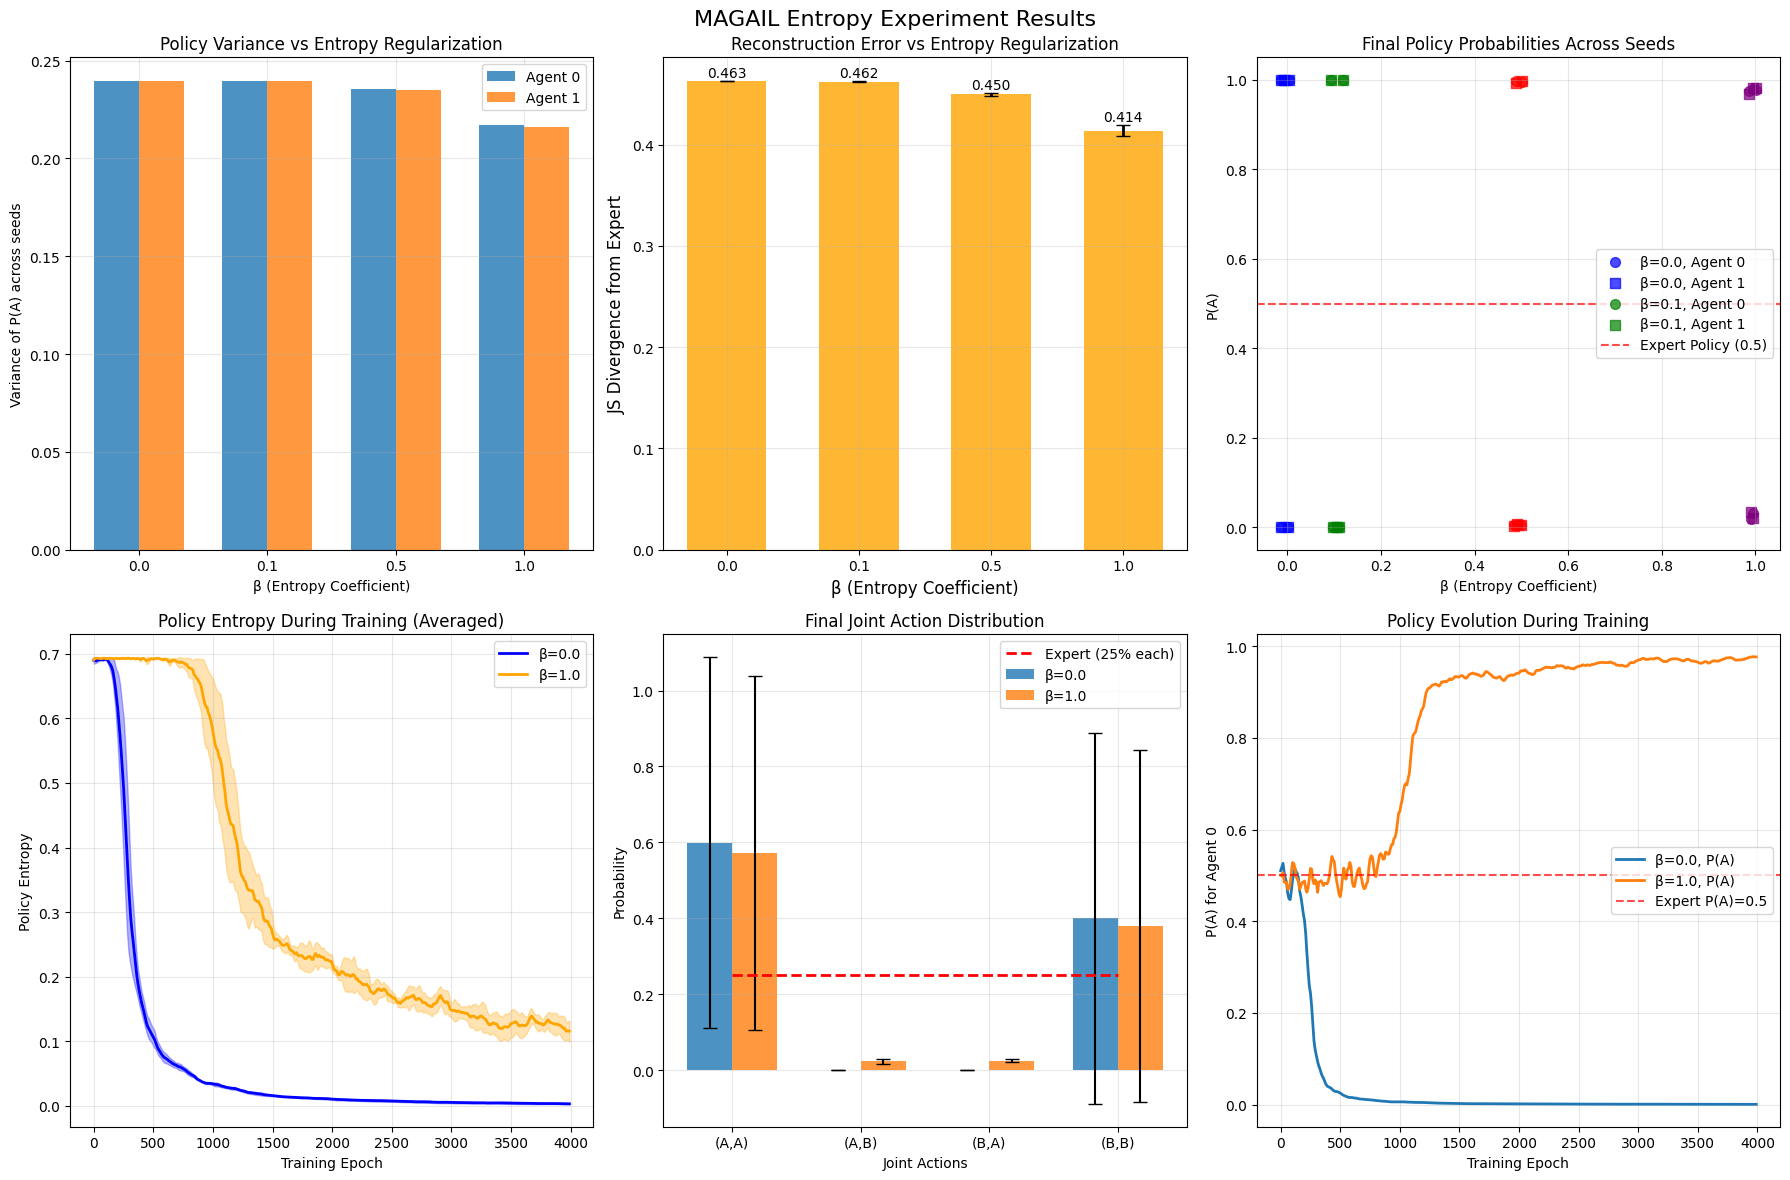

In [141]:

# Analyze results
print("\nAnalyzing results...")
analysis = analyze_results(results)

# Plot results
print("\nGenerating plots...")
plot_results(results, analysis)

In [142]:
def coordination_consistency(results):
    for beta in results.keys():
        coord_biases = []
        for seed in results[beta].keys():
            joint_dist = results[beta][seed]["history"]["joint_action_dist"][-1]
            # How much does this run favor coordination vs. anti-coordination?
            coord_prob = joint_dist[0] + joint_dist[3]  # (A,A) + (B,B)
            coord_biases.append(coord_prob)
        
        print(f"β={beta}: Mean coordination = {np.mean(coord_biases):.3f}, "
              f"Std = {np.std(coord_biases):.3f}")
        
coordination_consistency(results)

β=0.0: Mean coordination = 0.999, Std = 0.000
β=0.1: Mean coordination = 0.999, Std = 0.000
β=0.5: Mean coordination = 0.990, Std = 0.001
β=1.0: Mean coordination = 0.951, Std = 0.006
